In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from models import UNet, DiffusionModel
from train_utils import train, evaluate

In [2]:
config = {
    "epoch": 100,
    "batch_size": 128,
    "lr": 1e-4,
    "betas": (0.9,0.99),
    "weight_decay": 0,
    "T": 1000,
    "input_ch": 3,
    "channel": 128,
    "channel_mult": [1,2,3,4],
    "attn": [1],
    "num_res_blocks": 2,
    "dropout": 0.1,
    "beta_range": (1e-4, 0.02),
    "device": "cuda:0",
}

In [3]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

cifar10_train = torchvision.datasets.CIFAR10(
    root="./data/",
    train=True,
    download=True,
    transform=transform,
)

cifar10_eval = torchvision.datasets.CIFAR10(
    root="./data/",
    train=False,
    download=True,
    transform=transform,
)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
device = torch.device(config["device"])
print("device:",device)
model = UNet(
    T=config["T"], input_ch=config["input_ch"], ch=config["channel"], ch_mult=config["channel_mult"], attn=config["attn"],
    num_res_blocks=config["num_res_blocks"], dropout=config["dropout"]).to(device)

device: cuda:0


In [5]:
diffusion_model = DiffusionModel(model=model,beta_range=config["beta_range"],T=config["T"]).to(device)
print("number of parameters: ",sum(p.numel() for p in diffusion_model.parameters()))

number of parameters:  81444739


In [6]:
optimizer = torch.optim.Adam(diffusion_model.parameters(),lr=config["lr"],betas=config["betas"],weight_decay=config["weight_decay"])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer,T_max=config["epoch"])

In [7]:
train_dataloader = DataLoader(cifar10_train, batch_size=config["batch_size"], shuffle=True,)
eval_dataloader = DataLoader(cifar10_eval, batch_size=config["batch_size"])

In [ ]:
min_loss = 0.04

for epoch in range(config["epoch"]):
    print("epoch:",epoch+1)
    train(diffusion_model=diffusion_model, dataloader=train_dataloader, optimizer=optimizer, scheduler=scheduler ,verbose=True)
    eval_loss = evaluate(diffusion_model=diffusion_model, dataloader=eval_dataloader)

    if eval_loss < min_loss:
        print("saving model in epoch", epoch+1)
        file_name = "./checkpoints/cifar10_epoch"+str(epoch+1)+".pth"
        torch.save(diffusion_model.state_dict(), file_name)
        print("saved to ", file_name)
        min_loss = eval_loss

In [6]:
# load model
diffusion_model.load_state_dict(torch.load("checkpoints/cifar10_epoch50.pth"))

<All keys matched successfully>

In [16]:
print("saving model in epoch", epoch+1)
file_name = "./checkpoints/cifar10_epoch"+str(epoch+1)+".pth"
torch.save(diffusion_model.state_dict(), file_name)
print("saved to ", file_name)

saving model in epoch 100
saved to  ./checkpoints/cifar10_epoch100.pth


In [32]:
diffusion_model.load_state_dict(torch.load("checkpoints/cifar10_epoch80.pth"))

<All keys matched successfully>

In [33]:
noisyImage = torch.randn(
    size=[16, 3, 32, 32], device=device)

In [34]:
sampled_img, hiddens = diffusion_model.sample(noisyImage, verbose=True, return_hiddens=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [35]:
sampled_img.shape

torch.Size([16, 3, 32, 32])

In [36]:
sampled_img = sampled_img * 0.5 + 0.5  # [0 ~ 1]

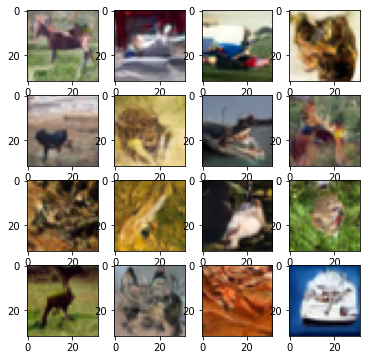

In [43]:
plt.figure(figsize=(6,6))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(sampled_img[i].cpu().permute((1,2,0)))

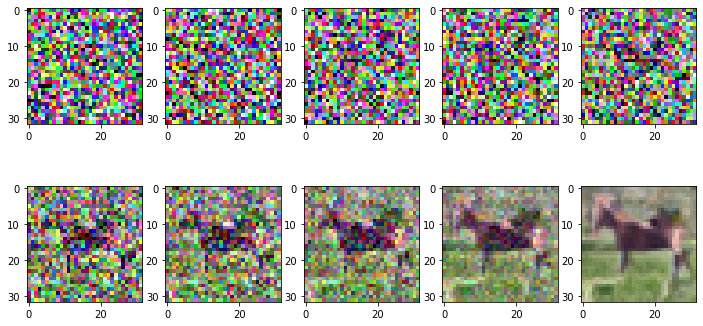

In [42]:
plt.figure(figsize=(12,6))
for i,time in enumerate([0,300,500,600,700,800,850,900,950,999]):
    plt.subplot(2,5,i+1)
    img = hiddens[time][0].clip(-1,1) * 0.5 + 0.5
    plt.imshow(img.cpu().permute((1,2,0)))